This notebook contains similarity preserving neural network training.

In [1]:
NUM_BITS = 512

In [2]:
from time import time
from pickle import load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from numpy.random import seed
seed(0)

from keras.models import Model
from keras.layers import Input, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.utils.vis_utils import plot_model
from tensorflow import set_random_seed
set_random_seed(0)

Using TensorFlow backend.


In [3]:
df = pd.read_csv('./dataset.csv', index_col=0)
df.head()

,color,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,...,Music,Romance,Documentary,Musical,Mystery,Horror,History,Animation,Film-Noir,Sport
Avatar,1.0,0.889163,0.529412,0.000000,0.037174,0.001563,1.000000,0.524453,0.007361,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pirates of the Caribbean: At World's End,1.0,0.370690,0.501548,0.024478,0.043478,0.062500,0.406840,0.278865,0.073622,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Spectre,1.0,0.740148,0.436533,0.000000,0.007000,0.017188,0.263080,0.163256,0.017816,0.023256,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Dark Knight Rises,1.0,1.000000,0.486068,0.956522,1.000000,0.042188,0.589253,0.677216,0.162561,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
John Carter,1.0,0.567734,0.386997,0.020652,0.023043,0.001000,0.096066,0.125579,0.002852,0.023256,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# load dict with similar/dissimilar movies
with open('./sims.pkl', 'rb') as f:
    movie_sims = load(f)

In [5]:
def create_pairs(movie_sims, df, split=0.85):
    """Creates positive/negative pairs for one-shot learning"""
    pairs = []
    labels = []

    for movie in movie_sims:
        # get vector for particular movie
        movie_vec = df.loc[movie].values
        # get vectors of its similar/dissimilar movies
        p_vec_l = [df.loc[movie].values for movie in movie_sims[movie]['pos']]
        n_vec_l =[df.loc[movie].values for movie in movie_sims[movie]['neg']]
        # construct pairs
        for pos, neg in zip(p_vec_l, n_vec_l):
            pairs += [[movie_vec, pos]]
            pairs += [[movie_vec, neg]]
            labels += [0, 1]
    
    # validation split
    split_indice = int(split * len(pairs))

    pairs_train = pairs[:split_indice]
    pairs_test = pairs[split_indice:]

    labels_train = labels[:split_indice]
    labels_test = labels[split_indice:]
    
    return ((np.array(pairs_train), np.array(labels_train)),
            (np.array(pairs_test), np.array(labels_test)))

In [6]:
def euclidean_distance(vects):
    """Compute euclidean distance."""
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return shape1[0], 1


def margin_loss(y_true, y_pred):
    m = 1
    loss = 0.5*(1-y_true)*y_pred + 0.5*y_true*K.maximum(0.0, m - y_pred)
    return loss


def create_base_network(input_shape, num_bit=NUM_BITS):
    """Base network architecture."""
    input = Input(shape=input_shape)
    x = Dense(60, activation='relu')(input)
    x = Dense(80, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(num_bit, activation='sigmoid')(x)
    return Model(input, x)


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.'''
    pred = y_pred.ravel() > 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.'''
    return K.mean(K.equal(y_true, K.cast(y_pred > 0.5, y_true.dtype)))

In [7]:
    print('Creating pairs ...')
    (x_train, y_train), (x_test, y_test) = create_pairs(movie_sims, df)
    print('Pairs created!')
    x_test = x_test.astype('float32')
    input_shape = [x_train.shape[-1]]
    print('Input shape:', input_shape[0])

    base_network = create_base_network(input_shape)

    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    L1_distance = lambda x: K.abs(x[0] - x[1])

    distance = Lambda(L1_distance,
                      output_shape=lambda x: x[0])([processed_a, processed_b])

    pred = Dense(1, activation='sigmoid')(distance)
    model = Model(input=[input_a, input_b], outputs=[pred])

    epochs = 60
    rms = RMSprop()
    
    x_train = x_train[:128]
    y_train = y_train[:128]
    
    early_stopping = EarlyStopping(patience=2, restore_best_weights=True)
    model.compile(loss=[margin_loss], optimizer=rms, metrics=['accuracy'])
    history = model.fit([x_train[:, 0], x_train[:, 1]], y_train,
                          batch_size=128,
                          epochs=epochs,
                          callbacks=[early_stopping], verbose=0)

Creating pairs ...
Pairs created!
Input shape: 41


/home/kuba/anaconda3/envs/lsh_tf36/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`
/home/kuba/anaconda3/envs/lsh_tf36/lib/python3.6/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


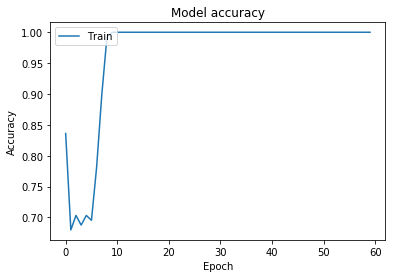

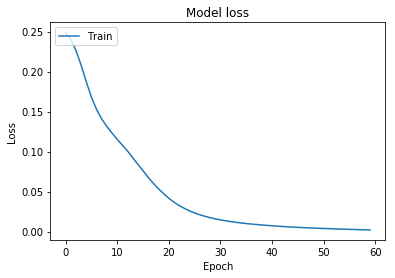

In [9]:
def plot_history(history, seed=1):
    """Saves plots of traning."""
    plt.figure(seed + 1)
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig('overfit_acc.png')
    

    plt.figure(seed + 2)
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    
    plt.show()

plot_history(history)